In [1]:
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.colors as colors
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import numpy             as np
import pandas            as pd
import seaborn           as sns
import xarray            as xr
from   pylab             import cm
from   scipy             import ndimage
import netCDF4
import yaml
import sys
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
land_regions = ['PacificNW'    , 'Southwest'    , 'NPlains'   , 'EastBoreal', 'Appalachia']
sea_regions  = ['WarmNEPacific', 'ColdNEPacific', 'GreatLakes', 'Hudson'    , 'WarmNWAtlantic']
bukovsky_regions = ['PacificNW'    , 'Southwest'    , 'NPlains'   , 'EastBoreal', 'Appalachia',
                    'WarmNEPacific', 'ColdNEPacific', 'GreatLakes', 'Hudson'    , 'WarmNWAtlantic']

In [3]:
#########################################################################
# Input arguments                                                       #
#########################################################################
working_directory =  '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures'
YYYYi             =  int(2014)
YYYYf             =  int(2015)
period            =  'MAM'

#########################################################################
# Hardcoded values                                                      #
#########################################################################
if   period == 'annual': MMs = [1,2,3,4,5,6,7,8,9,10,11,12]
elif period == 'DJF'   : MMs = [ 1, 2,12]
elif period == 'MAM'   : MMs = [ 3, 4, 5]
elif period == 'JJA'   : MMs = [ 6, 7, 8]
elif period == 'SON'   : MMs = [ 9,10,11]
else                   : MMs = [ int(period) ] # single month

#########################################################################
# Configuration file (yml)                                              #
#########################################################################
yml_file = working_directory + '/config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

weighted_mean = config['CALIPSOvsCOSP2vsGEM5_maps']['Profiles'] # Karel
#weighted_mean = config['CALIPSOvsCOSP2vsGEM5']                   # Vincent

# Template to loop over text files containing weighted mean information
bukovsky_template = weighted_mean + '/COSPOUT_weighted_mean/region/txt/YYYYMM.txt'

# MEAN SQUARED ERROR

In [4]:
DJF_mse_GEM5 = []
MAM_mse_GEM5 = []
JJA_mse_GEM5 = []
SON_mse_GEM5 = []

DJF_mse_COSP = []
MAM_mse_COSP = []
JJA_mse_COSP = []
SON_mse_COSP = []

# Main computing profiles

In [5]:
mean_profiles    = []

continental_GEM5 = []
continental_COSP = []
maritime_GEM5    = []
maritime_COSP    = []

altitude          = np.zeros(40) # Altitude
continental       = []           # Data land
oceanic           = []           # Data sea
annot_continental = []           # Annotation land
annot_maritime    = []           # Annotation sea
for regions in bukovsky_regions:
    # Computing main profiles
    #Period sum  
    GEM5_sum    = np.zeros(40)
    COSP2_sum   = np.zeros(40)
    CALIPSO_sum = np.zeros(40)
    #Period count (n) sum
    GEM5_n      = np.zeros(40)
    COSP2_n     = np.zeros(40)
    CALIPSO_n   = np.zeros(40)
        
    for year in [2014,2015]:
        for month in MMs:
            YYYYMM   = str(year) + str(month).zfill(2)
            txt_file = bukovsky_template.replace('region', regions).replace('YYYYMM',YYYYMM)
            
            columns           = ['altitude' , 'COSPIN_sum' , 'COSPIN_n' , 'COSPOUT_sum',
                                 'COSPOUT_n', 'CALIPSO_sum', 'CALIPSO_n'                ]
            df = pd.read_csv(txt_file,delimiter='\s+', header=0, names = columns)
            
            GEM5_sum    = GEM5_sum    + df['COSPIN_sum' ] 
            COSP2_sum   = COSP2_sum   + df['COSPOUT_sum']
            CALIPSO_sum = CALIPSO_sum + df['CALIPSO_sum']
            
            GEM5_n      = GEM5_n      + df['COSPIN_n'   ]
            COSP2_n     = COSP2_n     + df['COSPOUT_n'  ]
            CALIPSO_n   = CALIPSO_n   + df['CALIPSO_n'  ]
    # Mean profile for every dataset      
    altitude     = df['altitude']
    GEM5_mean    = GEM5_sum    / GEM5_n
    COSP2_mean   = COSP2_sum   / COSP2_n
    CALIPSO_mean = CALIPSO_sum / CALIPSO_n
    
    # Bias    
    bias_GEM5_CALIPSO = np.array(GEM5_mean  - CALIPSO_mean).tolist()
    bias_COSP_CALIPSO = np.array(COSP2_mean - CALIPSO_mean).tolist()
    
    # Mean square error
    mse_GEM5 = np.mean(np.array(bias_GEM5_CALIPSO[14:40])**2)
    mse_COSP = np.mean(np.array(bias_COSP_CALIPSO[14:40])**2)
    
    #Relative error 
    #1 (S - Obs)/(Obs)
    #error_GEM5 = abs((diff_GEM5_CALIPSO)/(CALIPSO_mean))
    #error_COSP = abs((diff_COSP_CALIPSO)/(CALIPSO_mean))
    
    #2 (S - Obs)/(S + Obs)
    error_GEM5 = (bias_GEM5_CALIPSO)/(CALIPSO_mean + GEM5_mean)
    error_COSP = (bias_COSP_CALIPSO)/(CALIPSO_mean + COSP2_mean)
    
    #DJF_mse_GEM5.append(mse_GEM5)
    #MAM_mse_GEM5.append(mse_GEM5)
    #JJA_mse_GEM5.append(mse_GEM5)
    #SON_mse_GEM5.append(mse_GEM5)

    #DJF_mse_COSP.append(mse_COSP)
    #MAM_mse_COSP.append(mse_COSP)
    #JJA_mse_COSP.append(mse_COSP)
    #SON_mse_COSP.append(mse_COSP)
    
    up = 8  
    low  = 40
    select_alt = altitude[up:low].tolist()

    if regions in land_regions:
        continental.append(CALIPSO_mean[up:low])
        #continental.append(bias_GEM5_CALIPSO[up:low])
        continental.append(bias_COSP_CALIPSO[up:low])
        continental.append(len(select_alt)*[np.nan])
        
        #continental_GEM5.append(bias_GEM5_CALIPSO)
        #continental_COSP.append(bias_COSP_CALIPSO)
        #Annotation sequence to fill the grid as follows (CALIPSO CF, error GEM5, error COSP2, nans)
        annot_continental.append(round(CALIPSO_mean[up:low],2))
        #annot_continental.append(round(error_GEM5  [up:low],2))
        annot_continental.append(round(error_COSP  [up:low],2))
        annot_continental.append(len(select_alt)*[np.nan])
    
    elif regions in sea_regions:
        oceanic.append(CALIPSO_mean     [up:low])
        #oceanic.append(bias_GEM5_CALIPSO[up:low])
        oceanic.append(bias_COSP_CALIPSO[up:low])
        oceanic.append(len(select_alt)*[np.nan])
        
        #maritime_GEM5.append(bias_GEM5_CALIPSO)
        #maritime_COSP.append(bias_COSP_CALIPSO)
        # Annotation sequence to fill the grid as follows (CALIPSO CF, error GEM5, error COSP2, nans)
        annot_maritime.append(round(CALIPSO_mean[up:low],2))
        #annot_maritime.append(round(error_GEM5  [up:low],2))
        annot_maritime.append(round(error_COSP  [up:low],2))
        annot_maritime.append(len(select_alt)*[np.nan])
    
    mean_profiles.append([GEM5_mean,COSP2_mean,CALIPSO_mean])


#conti_GEM5 = list(map(list, zip(*continental_GEM5)))
#conti_COSP = list(map(list, zip(*continental_COSP)))
#marit_GEM5 = list(map(list, zip(*maritime_GEM5)))
#marit_COSP = list(map(list, zip(*maritime_COSP)))

#### Mean heatmap inputs ####
# Annotation containing relative error
annot_conti = list(map(list, zip(*annot_continental)))
annot_mari  = list(map(list, zip(*annot_maritime)))
# Data from land and ocean eco-regions
land  = list(map(list, zip(*continental)))
ocean = list(map(list, zip(*oceanic)))

In [6]:
#mean_c_GEM5 = np.mean(conti_GEM5, axis = 1)
#mean_c_COSP = np.mean(conti_COSP, axis = 1)
#mean_m_GEM5 = np.mean(marit_GEM5, axis = 1)
#mean_m_COSP = np.mean(marit_COSP, axis = 1)

#mean = [mean_c_GEM5,mean_c_COSP,40*[np.nan],mean_m_GEM5,mean_m_COSP]
#mc = list(map(list, zip(*mean)))

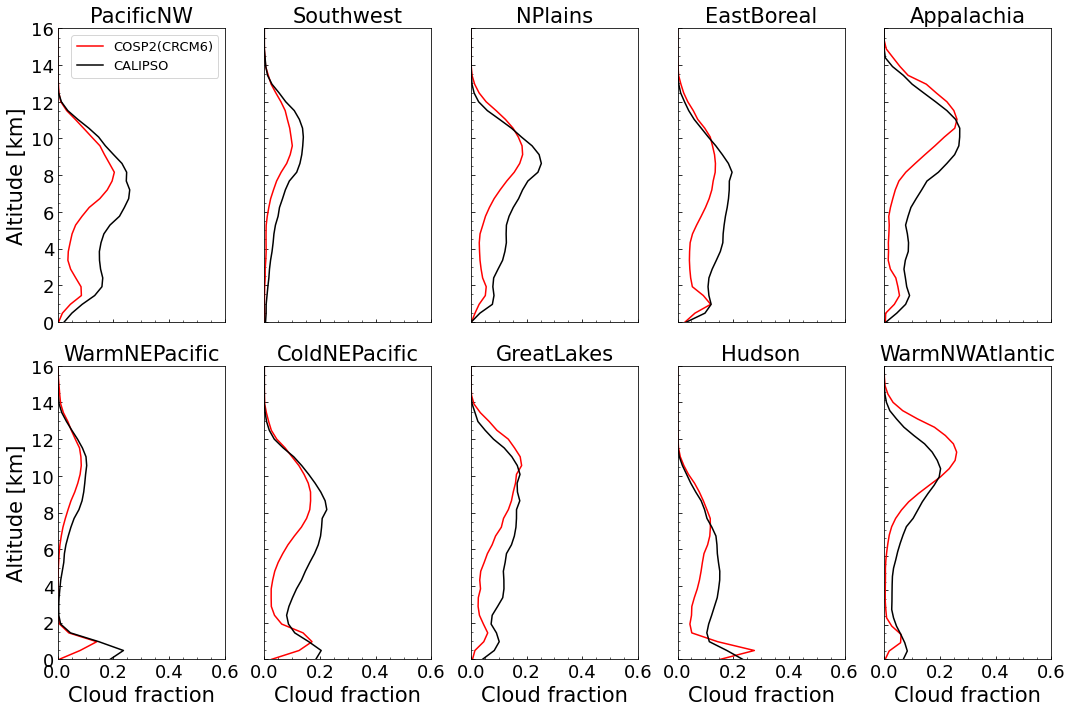

In [7]:
# Data 10 list
data = mean_profiles

# Assuming you have a list of location names
locations = bukovsky_regions
# Assuming you have column names for your datasets
columns = ['GEM5', 'COSP2', 'CALIPSO']

# Creating the DataFrame
df = pd.DataFrame(data, columns=columns, index=locations)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10), sharey = True, sharex = True)

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

xf = 0.6
# Loop through each location and plot on the corresponding subplot
for i, location in enumerate(df.index):
        GEM5    = df.loc[location]['GEM5']
        COSP2   = df.loc[location]['COSP2']
        CALIPSO = df.loc[location]['CALIPSO']

        #axes[i].plot(GEM5   , altitude, 'k-' , label = 'GEM5'   )
        axes[i].plot(COSP2  , altitude, 'k-', color = 'r', label = 'COSP2(CRCM6)'  )
        axes[i].plot(CALIPSO, altitude, 'k-' , label = 'CALIPSO')
        # x axis
        axes[i].set_xlim([0,xf])
        axes[i].set_xticks(np.arange(0,xf+0.2,0.2))
        # y axis
        axes[i].set_ylim(0,16)
        axes[i].set_yticks(np.arange(0,18,1))
        axes[i].set_yticklabels(np.arange(0,18,1))
        axes[i].locator_params(axis='y', nbins=12)
        #axes[i].set_ylabel('Altitude [km]', fontsize = 21)
        # Whole plot
        axes[i].tick_params(axis = 'both', which="both", labelsize =18,direction="in")
        axes[i].set_title(location, fontsize =21)
        
        axes[i].yaxis.get_ticklocs(minor=True)     # []
        axes[i].minorticks_on()
            
        if i > 4:
            axes[i].set_xlabel('Cloud fraction',fontsize = 21)

axes[0].legend(loc = 'upper right', prop = {'size':13})
axes[0].set_ylabel('Altitude [km]', fontsize = 21)
axes[5].set_ylabel('Altitude [km]', fontsize = 21)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('Figures/Cloudprofiles/{}_CF_profiles_COSPvsCALIPSO_{}-{}.png'.format(period,str(YYYYi),str(YYYYf)), format = 'png',bbox_inches = 'tight')

# Show the plots
plt.show()

In [69]:
def get_sym_cmap_norm(cc, lower, upper, n_shades):
    # n_colors always odd for a white band around zero
    n_colors = (2 * n_shades) + 1 
    cmap     = mpl.cm.get_cmap(cc, n_colors)
    bounds   = np.linspace(lower,upper,n_colors)
    norm     = mpl.colors.BoundaryNorm(bounds, n_colors)

    return cmap, norm, bounds

# build symmetric colormap around 0 from the data range
                                             #( cmap, lower, upper, n_shades in each hald of the color map)
c , norm_diff, bounds_diff = get_sym_cmap_norm("bwr", -1   , 1    , 11                                     )
cm, norm_maps, bounds_maps = get_sym_cmap_norm("viridis",0 , 1    , 5                                     )

# Heatmap with GEM5

[14.88, 14.4, 13.92, 13.44, 12.96, 12.48, 12.0, 11.52, 11.04, 10.56, 10.08, 9.6, 9.12, 8.64, 8.16, 7.68, 7.2, 6.72, 6.24, 5.76, 5.28, 4.8, 4.32, 3.84, 3.36, 2.88, 2.4, 1.92, 1.44, 0.96, 0.48, 0.0]


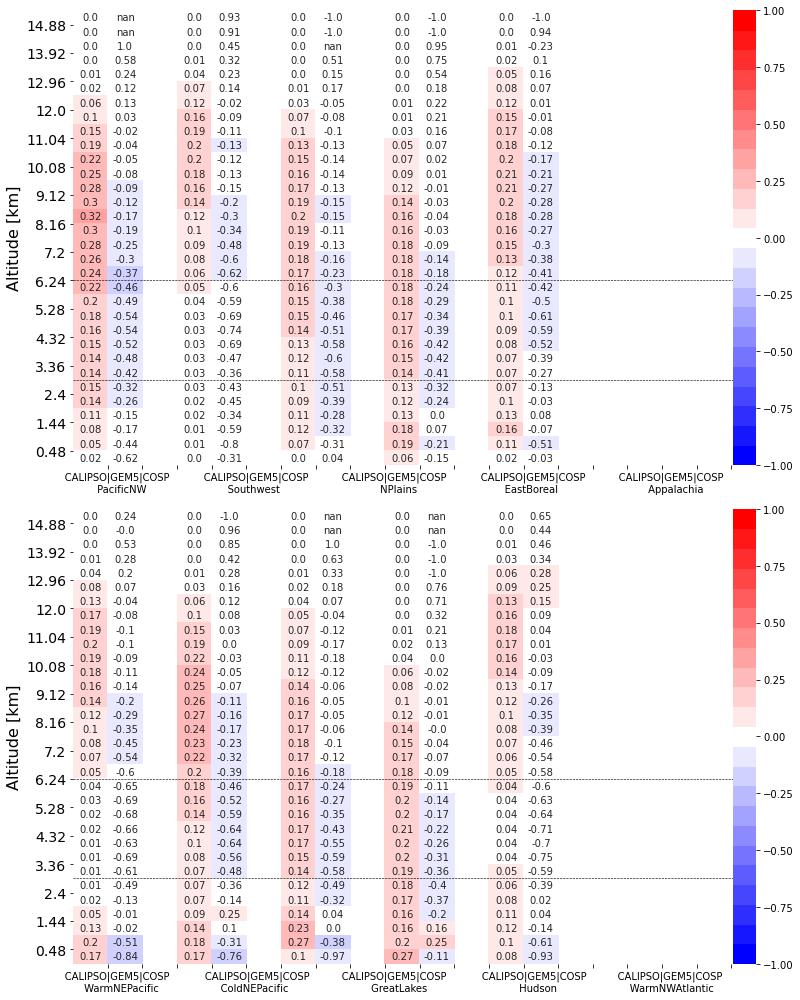

In [62]:
fig,ax = plt.subplots(2, 1, figsize=(12,14))
cc  = plt.get_cmap('seismic', 59)
#bounds_diff  = np.linspace(-1, 1, 59) 
#norm_diff    = mpl.colors.BoundaryNorm(bounds_diff, cc.N)
norm_diff = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1) # Norm centered at 0
alt = [ round(elem, 2) for elem in altitude.tolist()]

onland = sns.heatmap(land, cmap=c
                          , xticklabels=np.arange(0,20)                        
                          , vmin=-1, vmax=1
                          , annot=annot_conti, fmt=""
                          , cbar_kws={"pad": -0.02}
                          , ax = ax[0]
                          , norm = norm_diff)

oocean = sns.heatmap(ocean, cmap=c
                          , xticklabels=np.arange(0,20)                         
                          , vmin=-1, vmax=1
                          , annot=annot_mari, fmt=""
                          , cbar_kws={"pad": -0.02}
                          , ax = ax[1]
                          , norm = norm_diff)

land_ticks =  ['      CALIPSO|GEM5|COSP\n         PacificNW','','','', '      CALIPSO|GEM5|COSP\n     Southwest','','','',
               '      CALIPSO|GEM5|COSP\n         NPlains'  ,'','','', '      CALIPSO|GEM5|COSP\n     EastBoreal'  ,'','','',
               '      CALIPSO|GEM5|COSP\n         Appalachia','','']
ocean_ticks = ['      CALIPSO|GEM5|COSP\n         WarmNEPacific','','','', '       CALIPSO|GEM5|COSP\n     ColdNEPacific','','','',
               '      CALIPSO|GEM5|COSP\n         GreatLakes','','','', '       CALIPSO|GEM5|COSP\n         Hudson','','','', '     CALIPSO|GEM5|COSP\n      WarmNWAtlantic','','']

print(alt[8:40])
for i in range(2):
    ax[i].set_xticks(np.arange(1,20))
    ax[i].set_yticks(np.arange(1,33))
    ax[i].set_yticklabels(alt[8:40],rotation = 360, fontsize = 14)
    ax[i].locator_params(axis='y', nbins=20)
    ax[i].set_ylabel('Altitude [km]', fontsize = 16)
    ax[i].axhline(y=19, color='k', linestyle='--', linewidth = 0.6)
    ax[i].axhline(y=26, color='k', linestyle='--', linewidth = 0.6)

ax[0].set_xticklabels(land_ticks)
ax[1].set_xticklabels(ocean_ticks)
plt.tight_layout()
plt.show()

# Heatmap without GEM5

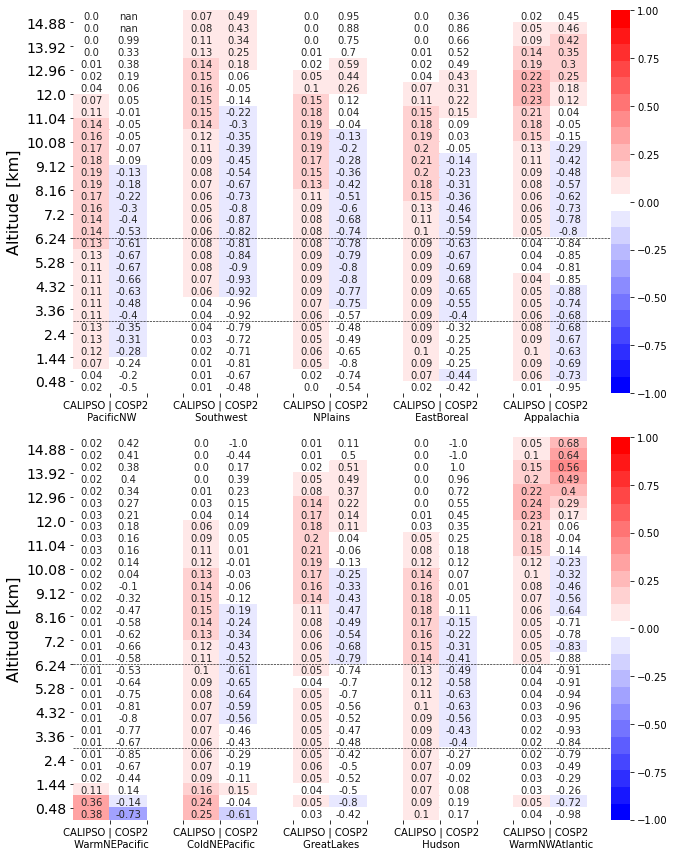

In [75]:
fig,ax = plt.subplots(2, 1, figsize=(10,12))

norm_diff = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1) # Norm centered at 0
alt = [ round(elem, 2) for elem in altitude.tolist()]

onland = sns.heatmap(land, cmap=c
                          , xticklabels=np.arange(0,15)                        
                          , vmin=-1, vmax=1
                          , annot=annot_conti, fmt=""
                          , cbar_kws={"pad": -0.02}
                          , ax = ax[0]
                          , norm = norm_diff)

oocean = sns.heatmap(ocean, cmap=c
                          , xticklabels=np.arange(0,15)                         
                          , vmin=-1, vmax=1
                          , annot=annot_mari, fmt=""
                          , cbar_kws={"pad": -0.02}
                          , ax = ax[1]
                          , norm = norm_diff)
   
land_ticks =  [' CALIPSO | COSP2    \n PacificNW','','', ' CALIPSO | COSP2    \n Southwest','','',
               ' CALIPSO | COSP2    \n NPlains'  ,'','', ' CALIPSO | COSP2    \n EastBoreal'  ,'','',
               ' CALIPSO | COSP2    \n Appalachia']
ocean_ticks = [' CALIPSO | COSP2    \n WarmNEPacific','','', ' CALIPSO | COSP2    \n ColdNEPacific','','',
               ' CALIPSO | COSP2    \n GreatLakes','','', ' CALIPSO | COSP2   \n Hudson','','', ' CALIPSO | COSP2    \n WarmNWAtlantic']
for i in range(2):   
    ax[i].set_xticks(np.arange(1,14))
    ax[i].set_yticks(np.arange(1,33))
    ax[i].set_yticklabels(alt[8:40],rotation = 360, fontsize = 14)
    ax[i].locator_params(axis='y', nbins=20)
    ax[i].set_ylabel('Altitude [km]', fontsize = 16)
    ax[i].axhline(y=19, color='k', linestyle='--', linewidth = 0.6)
    ax[i].axhline(y=26, color='k', linestyle='--', linewidth = 0.6)

ax[0].set_xticklabels(land_ticks)
ax[1].set_xticklabels(ocean_ticks)
plt.tight_layout()
plt.show()

# MEAN LAND & SEA 

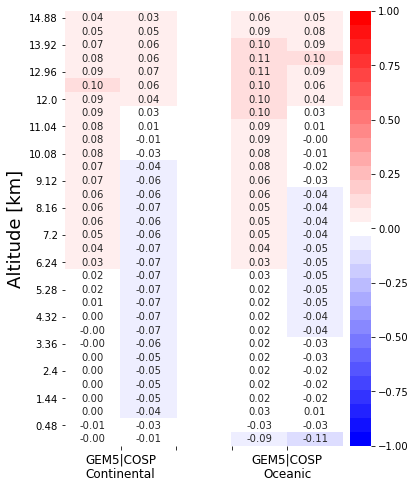

In [102]:
# Generate sample data (replace this with your actual data)
pressure_levels = np.arange(1, 41)
geographical_regions = np.arange(1, 5)
data = mc

# Create a heatmap using Seaborn
fig = plt.figure(figsize=(6, 8))

# Adjust the position of x-axis ticks to add blank spaces
heatmap = sns.heatmap(data[8:40] , cmap=c
                                 , xticklabels=geographical_regions
                                 , yticklabels=alt[8:40]
                                 , vmin=-1, vmax=1
                                 , annot=True, fmt=".2f"
                                 , cbar_kws={"pad": 0.02}
                                 ,norm = norm_diff)

alt = [ round(elem, 2) for elem in altitude.tolist()]
plt.locator_params(axis='y', nbins=20)

territories = ['GEM5|COSP\nContinental' ,'','', 'GEM5|COSP\nOceanic']
plt.xticks(geographical_regions, territories,fontsize = 12)  # Adjust the values to control the spacing
plt.ylabel('Altitude [km]', fontsize = 18)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

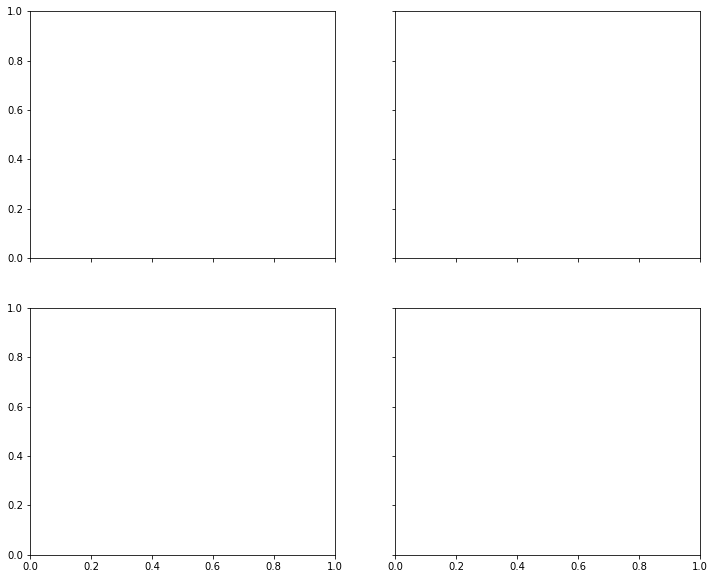

In [36]:
categories = ['CategoryA', 'CategoryB']

fig, ax = plt.subplots(2,2,figsize=(12, 10), sharey = True, sharex = True)

bar_width = 0.35
bar_positions = np.arange(len(bukovsky_regions))
# DJF
bar1 = ax[0,0].bar(bar_positions - bar_width/2, DJF_mse_GEM5, bar_width, label='GEM5', color = 'darkcyan')
bar2 = ax[0,0].bar(bar_positions + bar_width/2, DJF_mse_COSP, bar_width, label='COSP2', color = 'darkorange')
#MAM
bar1 = ax[0,1].bar(bar_positions - bar_width/2, MAM_mse_GEM5, bar_width, label='GEM5', color = 'darkcyan')
bar2 = ax[0,1].bar(bar_positions + bar_width/2, MAM_mse_COSP, bar_width, label='COSP2', color = 'darkorange')
#JJA
bar1 = ax[1,0].bar(bar_positions - bar_width/2, JJA_mse_GEM5, bar_width, label='GEM5', color = 'darkcyan')
bar2 = ax[1,0].bar(bar_positions + bar_width/2, JJA_mse_COSP, bar_width, label='COSP2', color = 'darkorange')
#SON
bar1 = ax[1,1].bar(bar_positions - bar_width/2, SON_mse_GEM5, bar_width, label='GEM5', color = 'darkcyan')
bar2 = ax[1,1].bar(bar_positions + bar_width/2, SON_mse_COSP, bar_width, label='COSP2', color = 'darkorange')

xticks_regions = ['PacificNW'    , 'Southwest'    , 'NPlains'   , 'EastBoreal', 'Appalachia',
                    'WarmNE\nPacific', 'ColdNE\nPacific', 'GreatLakes', 'Hudson'    , 'WarmNW\nAtlantic']

for i in range(2):
    for j in range(2):
        ax[i,j].set_xticks(np.arange(0,10))
        ax[i,j].set_ylim(0,0.03)
        ax[i,j].set_xticklabels(xticks_regions,rotation = 270, fontsize = 13)
        ax[i,j].grid(axis = 'y')

ax[1,1].legend()
    
ax[0,0].annotate('a)', xy=(.06, .945),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[0,1].annotate('b)', xy=(.538, .945),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[1,0].annotate('c)', xy=(.06, .5),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[1,1].annotate('d)', xy=(.538, .5),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)
plt.tight_layout()
plt.show()

7


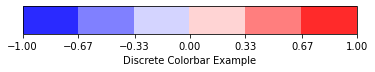

8


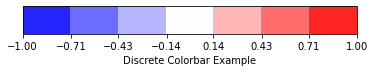

9


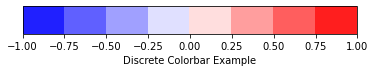

10


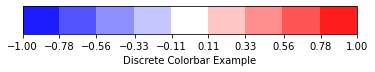

11


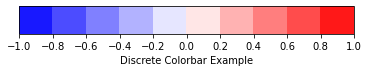

12


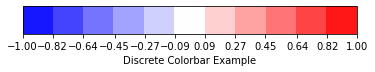

13


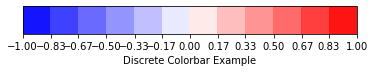

14


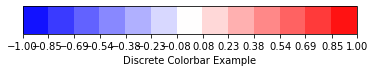

15


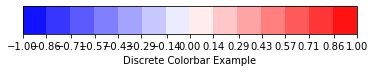

16


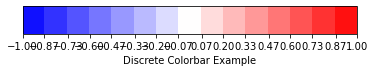

17


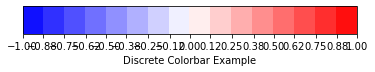

18


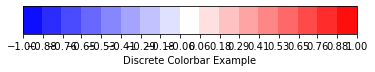

19


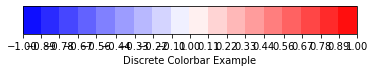

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def colorbar(num):
    # Define the custom colormap
    colors = ['blue', 'white', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Define the normalization to center white at 0
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

    # Create a colorbar with discrete intervals
    bounds = np.linspace(-1, 1, num=num)  # 6 intervals between -1 and 1
    ticks = bounds

    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    cbar = fig.colorbar(
        cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=ax,
        orientation='horizontal',
        boundaries=bounds,
        ticks=np.round(ticks,2)
    )

    # Label the colorbar
    cbar.set_label('Discrete Colorbar Example')

    plt.show()

for i in range(7,20):
    print(i)
    colorbar(i)